In [1]:

import os
import numpy as np
from scipy.io import loadmat
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import timecorr as tc
import math
import scipy.spatial.distance as sd
from timecorr.helpers import isfc, autofc, mean_combine, corrmean_combine, vec2mat, reduce
%matplotlib inline
chunk_size=6

In [2]:

def _plot_borderless_clustered(x, factor_bounds=None, factor_colors=None, savefile=None, vmin=-1, vmax=1, cbar=False, width=1000, dpi=100, cmap='Spectral_r'):
    _close_all()
    width *= (1000.0 / 775.0)  # account for border
    height = (775.0 / 755.0) * float(width) * float(x.shape[0]) / float(x.shape[1])  # correct height/width distortion

    fig = plt.figure(figsize=(width / float(dpi), height / float(dpi)), dpi=dpi)

    if len(x.shape) == 2:
        im = plt.pcolormesh(x, vmin=float(vmin), vmax=float(vmax), cmap=cmap)
    else:
        plt.imshow(x)
    ax = plt.gca()
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    for _, spine in ax.spines.items():
        spine.set_visible(True)

    if factor_bounds:

        ax.hlines(factor_bounds, *ax.get_xlim(), linewidth=2, colors='w')
        ax.vlines(factor_bounds, *ax.get_ylim(), linewidth=2, colors='w')

    if factor_colors:
        for i, f in enumerate(factor_bounds[:-1]):
            rect = patches.Rectangle((f,f), factor_bounds[i+1]-f-1, factor_bounds[i+1]-f-1, linewidth=6, edgecolor=factor_colors[i],facecolor='none', zorder=2)
            ax.add_patch(rect)


    fig.set_frameon(False)
    if cbar:
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.tick_params(labelsize=30)
    
    if not savefile == None:
        fig.savefig(savefile, figsize=(width / float(dpi), height / float(dpi)), bbox_inches='tight', pad_inches=0,
                    dpi=dpi)
    return fig


In [3]:
def _close_all():
    figs = plt.get_fignums()
    for f in figs:
        plt.close(f)

In [4]:
# def squareform_timepoints_corr(all_data, order=0):
    
#     chunks = range(0, math.ceil(all_data/chunk_size))
#     for ch in chunks:

#         start = ch * chunk_size
#         stop = (ch + 1) * chunk_size

#         if not ch == chunks[-1]:
#             chunk_data = all_data[conds == c][start:stop]
#         else:
#             chunk_data = all_data[conds == c][start:]

    
#     if not order == 0:
#         for o in range(order):
#             data = np.asarray(tc.timecorr([x for x in data], cfun=autofc, rfun=rfun, combine=None,
#                                                  weights_function=weights_fun, weights_params=weights_params))
#     sq_corr = np.array([])
#     for i in data:
#         corr = np.corrcoef(i)
#         if sq_corr.size == 0:
#             sq_corr = sd.squareform(corr, checks=False)
#         else:
#             sq_corr = np.vstack((sq_corr, sd.squareform(corr, checks=False)))
    
#     return sq_corr

In [5]:

def squareform_timepoints_corr(data, order=0):
    if not order == 0:
        for o in range(order):
            data = np.asarray(tc.timecorr([x for x in data], cfun=autofc, rfun=rfun,
                                                 weights_function=weights_fun, weights_params=weights_params))
    sq_corr = np.array([])
    for i in data:
        corr = np.corrcoef(i)
        if sq_corr.size == 0:
            sq_corr = sd.squareform(corr, checks=False)
        else:
            sq_corr = np.vstack((sq_corr, sd.squareform(corr, checks=False)))
    
    return sq_corr

In [6]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [7]:
factors = 700

In [8]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'


In [9]:
pieman_data = loadmat(pieman_name)

In [10]:
pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [11]:
debug = False

In [12]:
if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:2000,:100], np.arange(4)))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0][:272,:], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0][:272,:], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0][:272,:], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [13]:
np.shape(data)

(125, 272, 700)

In [14]:
all_data = np.array(data)
conds = np.array(conds)


In [15]:
cfun = isfc
rfun = 'PCA'
width = 10
wp = 'gaussian'
cond = 'intact'
level = 1

gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': width}}

weights_paramter = eval(wp)


weights_fun=weights_paramter['weights']
weights_params=weights_paramter['params']
combine = corrmean_combine

In [16]:
all_stack = np.array([])
factor_list = [0]
factor_list_sum = 0
for c in pieman_conds:
    c_stack = squareform_timepoints_corr(all_data[conds == c])
    factor_list.append(factor_list[-1] + len(c_stack))
    if all_stack.size == 0:
        all_stack = c_stack
    else:
        all_stack = np.vstack((all_stack,c_stack))

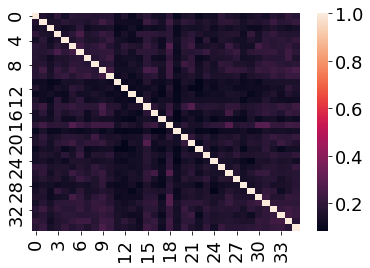

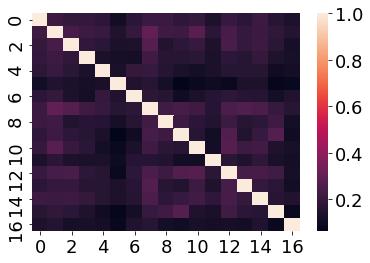

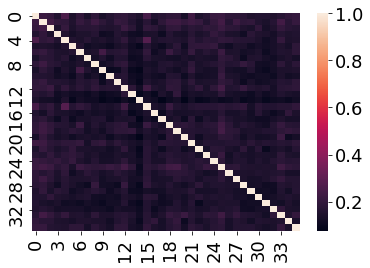

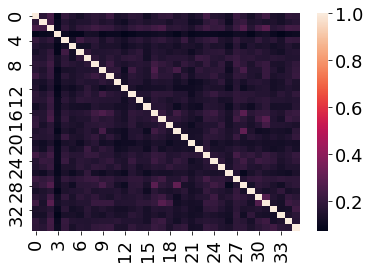

<Figure size 432x288 with 0 Axes>

In [17]:
for i, f in enumerate(factor_list[:-1]):
    sns.heatmap(np.corrcoef(all_stack[f:factor_list[i+1], :]))
    plt.show()
    plt.clf()

In [18]:
factors=700

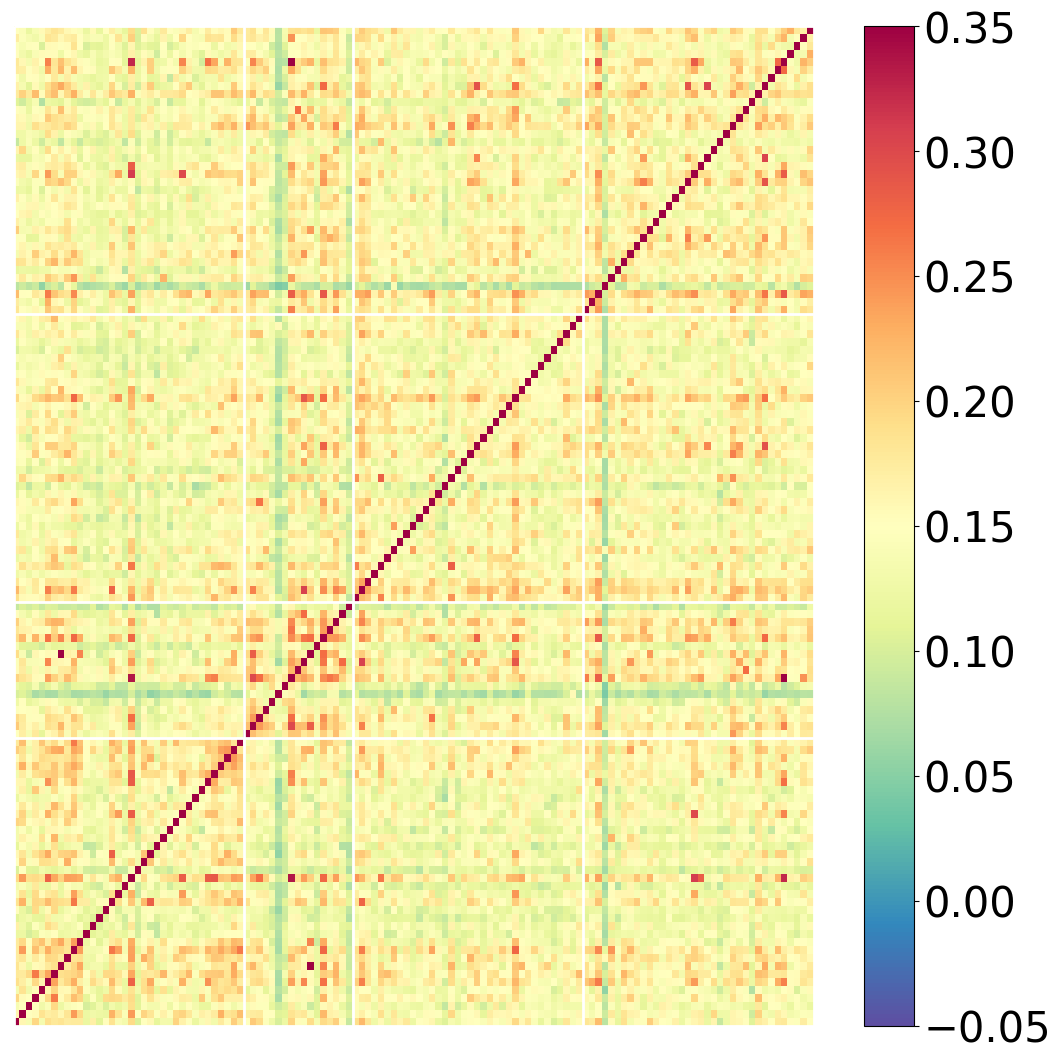

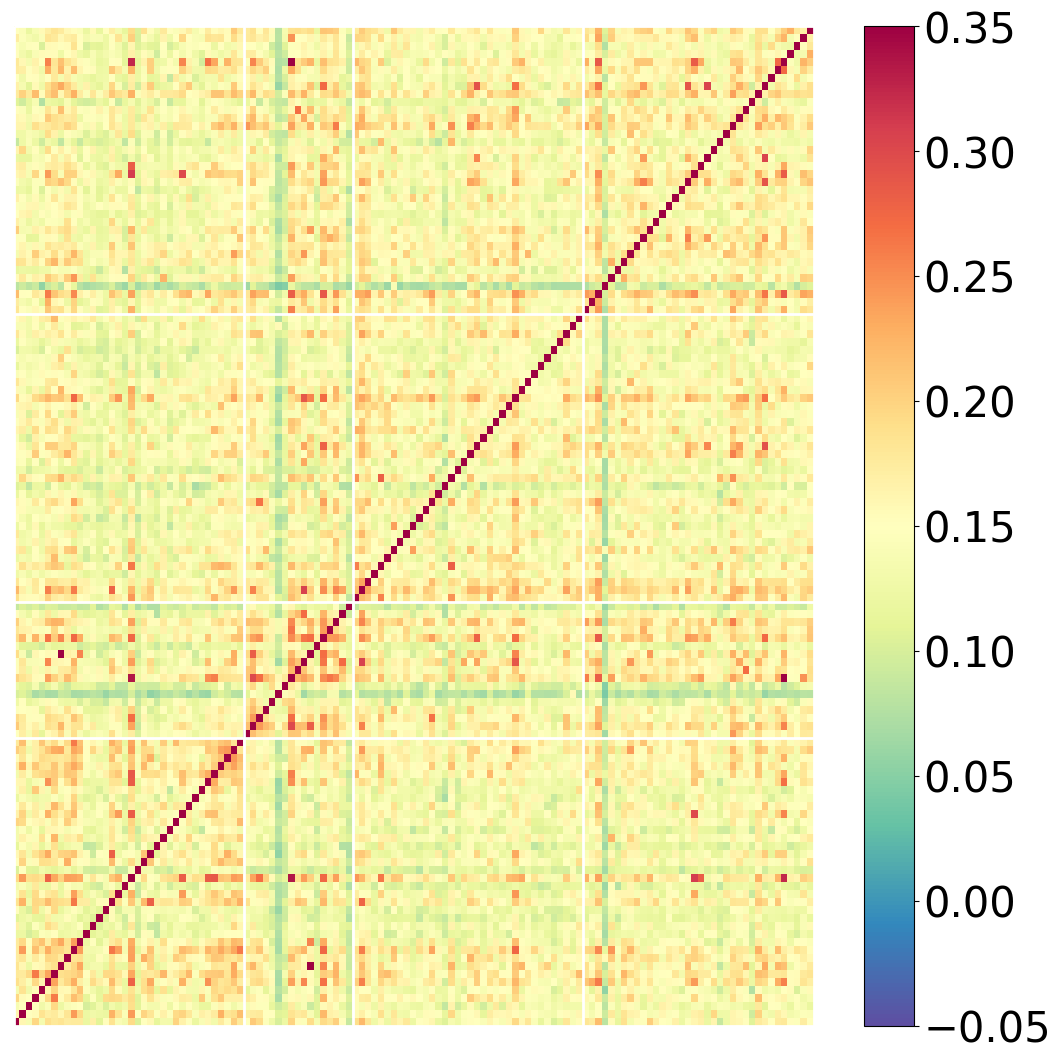

In [19]:
outfile = os.path.join(figdir,  'L0_heatmap_'+ str(factors)+ '.pdf')
_plot_borderless_clustered(np.corrcoef(all_stack), factor_bounds=factor_list, cbar=True, vmin=-.05, vmax=.35, cmap='Spectral_r', savefile=outfile)

In [20]:
full_data = pd.DataFrame()
for i, f in enumerate(factor_list[:-1]):
    part_data = pd.DataFrame({'Corr': np.corrcoef(all_stack[f:factor_list[i+1], :]).mean(axis=1)})
    part_data['Cond'] = pieman_conds[i]

    full_data = full_data.append(part_data)

In [21]:
full_data = full_data.reset_index()

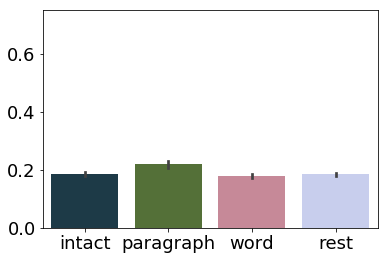

In [22]:
outfile = os.path.join(figdir,  'L0_barplot_'+ str(factors)+ '.pdf')
g = sns.barplot(x=full_data.Cond, y=full_data.Corr,estimator=np.mean, ci=95, n_boot=1000,palette="cubehelix")
g.set(ylim=(0, .75))
plt.ylabel('')
plt.xlabel('')
plt.savefig(outfile, bbox_inches='tight')

In [23]:
all_stack_1 = np.load('./figs/level_1.npy')

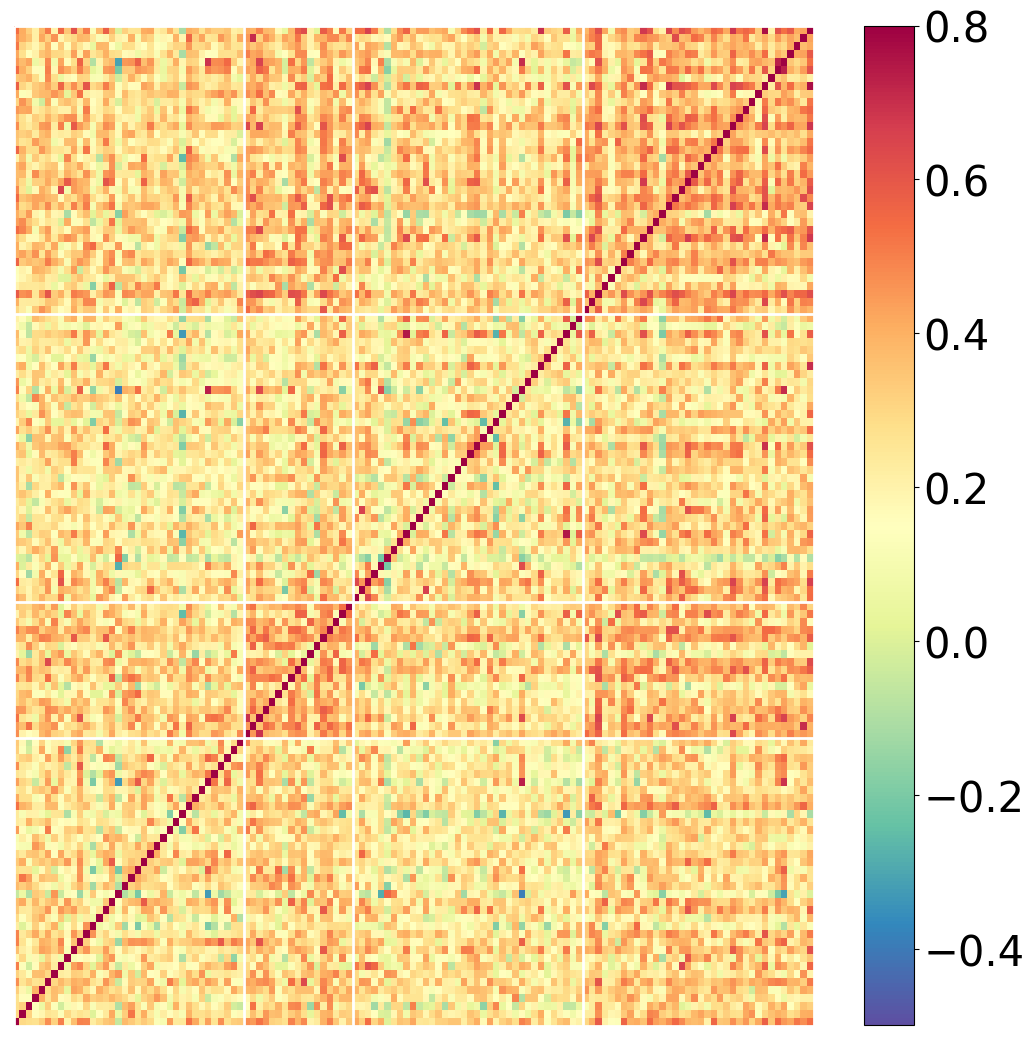

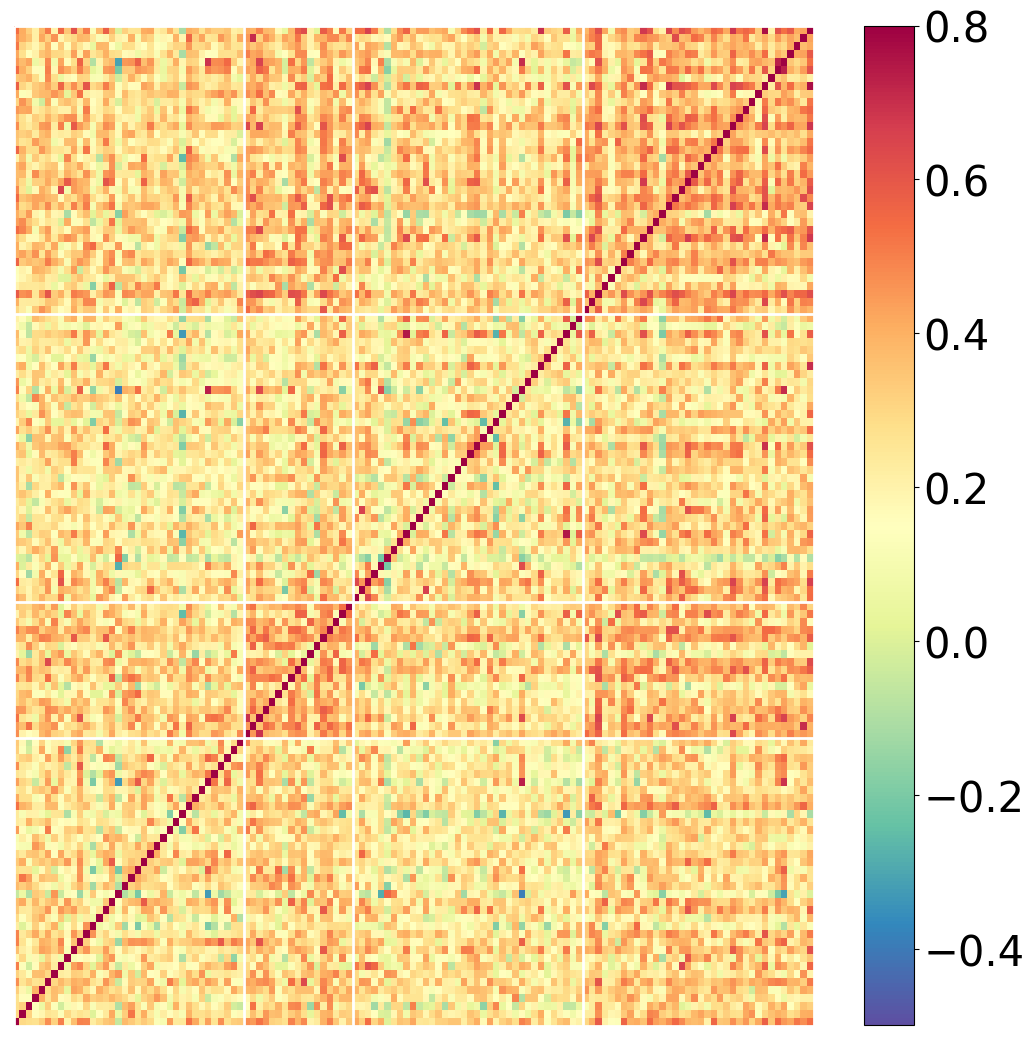

In [24]:
outfile = os.path.join(figdir,  'L1_heatmap_'+ str(factors)+ '.pdf')
_plot_borderless_clustered(np.corrcoef(all_stack_1), factor_bounds=factor_list, cbar=True, vmin=-.5, vmax=.8, savefile=outfile)

In [25]:
full_data = pd.DataFrame()
for i, f in enumerate(factor_list[:-1]):
    part_data = pd.DataFrame({'Corr': np.corrcoef(all_stack_1[f:factor_list[i+1], :]).mean(axis=1)})
    part_data['Cond'] = pieman_conds[i]

    full_data = full_data.append(part_data)

In [26]:
full_data = full_data.reset_index()

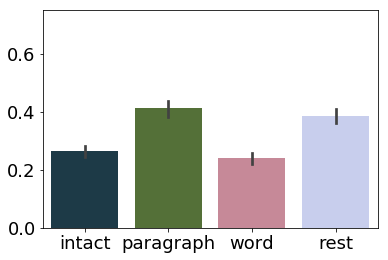

In [27]:
outfile = os.path.join(figdir,  'L1_barplot_'+ str(factors)+ '.pdf')
g = sns.barplot(x=full_data.Cond, y=full_data.Corr, estimator=np.mean, ci=95, n_boot=1000,palette="cubehelix")
g.set(ylim=(0, .75))
plt.ylabel('')
plt.xlabel('')
plt.savefig(outfile, bbox_inches='tight')

In [28]:
all_stack_2 = np.load('./figs/level_2.npy')

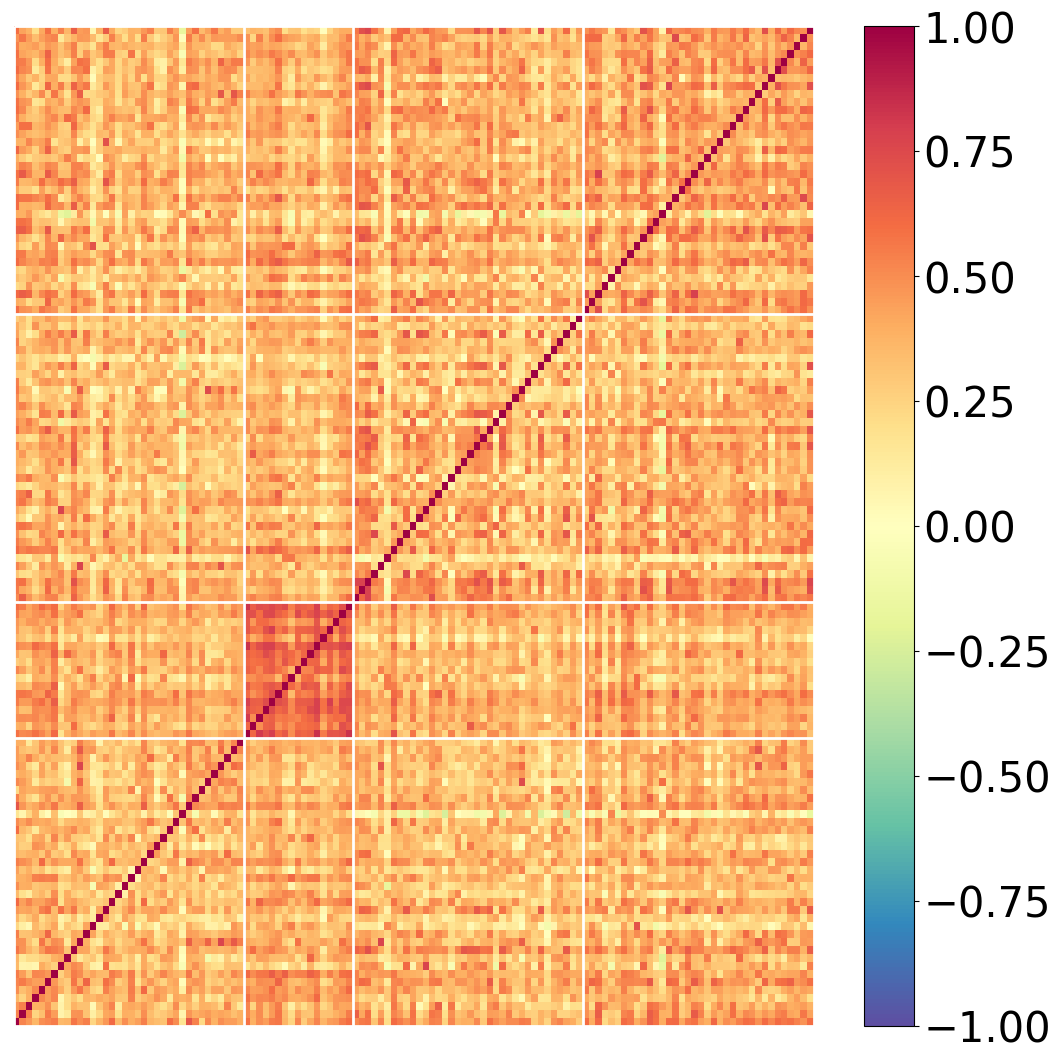

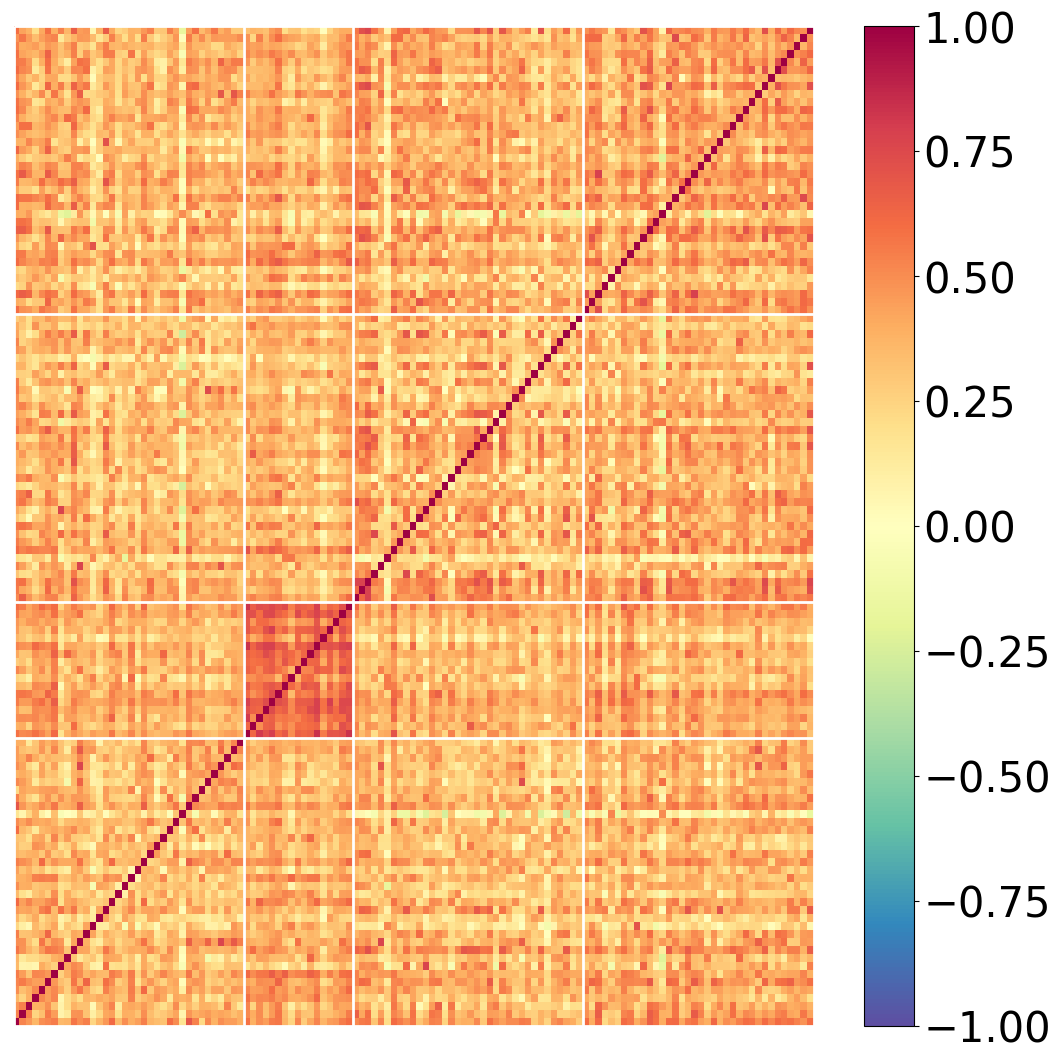

In [29]:
outfile = os.path.join(figdir,  'L2_heatmap_'+ str(factors)+ '.pdf')
_plot_borderless_clustered(np.corrcoef(all_stack_2), factor_bounds=factor_list, cbar=True, vmin=-1, vmax=1, savefile=outfile)

In [30]:
full_data = pd.DataFrame()
for i, f in enumerate(factor_list[:-1]):
    part_data = pd.DataFrame({'Corr': np.corrcoef(all_stack_2[f:factor_list[i+1], :]).mean(axis=1)})
    part_data['Cond'] = pieman_conds[i]

    full_data = full_data.append(part_data)

In [31]:
full_data = full_data.reset_index()

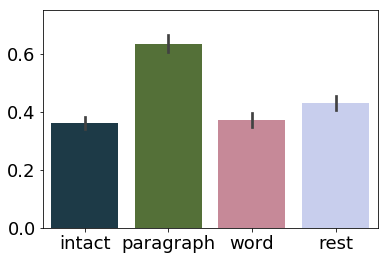

In [32]:
outfile = os.path.join(figdir,  'L2_barplot_'+ str(factors)+ '.pdf')
g = sns.barplot(x=full_data.Cond, y=full_data.Corr, estimator=np.mean, ci=95, n_boot=1000,palette="cubehelix")
g.set(ylim=(0, .75))
plt.ylabel('')
plt.xlabel('')
plt.savefig(outfile, bbox_inches='tight')

In [ ]:
all_stack_3 = np.array([])
factor_list = [0]
factor_list_sum = 0
for c in pieman_conds:
    c_stack = squareform_timepoints_corr(all_data[conds == c], order=3)
    factor_list.append(factor_list[-1] + len(c_stack))
    if all_stack_3.size == 0:
        all_stack_3 = c_stack
    else:
        all_stack_3 = np.vstack((all_stack_3,c_stack))

In [ ]:
outfile = os.path.join(figdir,  'L3_heatmap_'+ str(factors)+ '.pdf')
_plot_borderless_clustered(np.corrcoef(all_stack_3), factor_bounds=factor_list, cbar=True, vmin=-1, vmax=1, savefile=outfile)

In [42]:
full_data = pd.DataFrame()
for i, f in enumerate(factor_list[:-1]):
    part_data = pd.DataFrame({'Corr': np.corrcoef(all_stack_3[f:factor_list[i+1], :]).mean(axis=1)})
    part_data['Cond'] = pieman_conds[i]

    full_data = full_data.append(part_data)

In [43]:
full_data = full_data.reset_index()

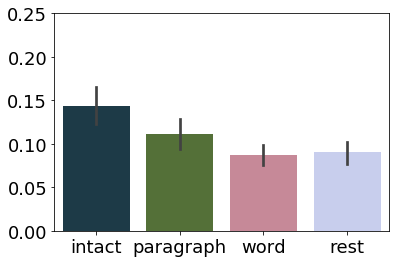

In [44]:
outfile = os.path.join(figdir,  'L3_barplot_'+ str(factors)+ '.pdf')
g = sns.barplot(x=full_data.Cond, y=full_data.Corr, estimator=np.mean, ci=95, n_boot=1000,palette="cubehelix")
g.set(ylim=(0, .25))
plt.ylabel('')
plt.xlabel('')
plt.savefig(outfile, bbox_inches='tight')